In [2]:
import numpy as np
import math
import os
import time
import re

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec

from scipy.ndimage import imread
from scipy import ndimage
from scipy.signal import fftconvolve
from scipy.ndimage.filters import gaussian_filter
from skimage.feature import peak_local_max, canny
from skimage.measure import regionprops
from skimage.filters.rank import gradient
from skimage.filters import sobel
from skimage import data, img_as_float

from PIL import Image
import pandas as pd

from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets

from correlation import *
from utils import read_tiff, scan_directory_tree, update_slice, make_dir

In [2]:
root_path = u'y:\\projects\\pn-reduction\\2018_03_esrf_mi1325\\Phantom\\Glasduese\\'

datasets = scan_directory_tree(root_path)

Start scanning
End scanning
In total 116 datasets


In [4]:
path = datasets[0]
print(path)
#print(re.search(r'Ansicht[ ][0-9][°]', path))

#for d in datasets:
    #res = re.findall(r'[0-9]+°C', d)
    #res = r.group()[:-1] if r else 'Ansicht ?'
    

    
    #print(res[0:2], ' ', res[2:4])
    #print(datasets.index(d))
    
# Parse data catalog
days     = list(map(lambda p: re.search(r'([0-9.]+[ ]auf[ ][0-9.]+)', p).group().replace(' auf ', '-'), datasets))
sample   = list(map(lambda p: re.search(r'([0-9]+[_][0-9][\\])', p).group()[:-1], datasets))
view     = list(map(lambda p: re.search(r'Ansicht[ ][0-9]+[°]', p).group()[:-1] if re.search(r'Ansicht[ ][0-9]+[°]', p) else 'Ansicht ?', datasets))
op       = list(map(lambda p: re.search(r'OP_[0-9,]+bar', p).group()[3:], datasets))
temp1    = list(map(lambda p: re.findall(r'[0-9]+°C', p)[0], datasets))
pressure = list(map(lambda p: re.search(r'[12][05][0]bar', p).group()[:-3], datasets))
temp2    = list(map(lambda p: re.findall(r'[0-9]+°C', p)[1], datasets))
region   = list(map(lambda p: re.search(r'([Z][0-9.]+[Y][0-9.]+)', p).group()[:], datasets))
datapath = list(map(lambda p: '\\'.join(p.split('\\')[:][:-1]), datasets))
filename = list(map(lambda p: p.split('\\')[-1:][0].replace(u"\xb0", "")[:-5] + '.tif', datasets))

#print(file_name)
#print(len(file_name))

y:\projects\pn-reduction\2018_03_esrf_mi1325\Phantom\Glasduese\Nachtschicht 11.3 auf 12.3\025_3\Ansicht off\OP_1bar_25°C_100bar_25°C\Z0Y0\OP_1bar_25°C_100bar_25°C.cine


In [5]:
df = pd.DataFrame({ 'days'    : days,
                    'geometry': sample,
                     'view'   : view ,
                     'op'     : op,
                     'temp1'  : temp1,
                     'press'  : pressure,
                     'temp2'  : temp2,
                     'region' : region,
                     'file'   : filename,
                     'path'   : datapath                   
                  })


#writer = pd.ExcelWriter('esrf_march_glasduese_datasets.xlsx')
#df.to_excel(writer,'09-12 March 2018 - Glasdüse')
#writer.save()

In [17]:
# all datasets, without path info
#print(df[df.columns[:-2]])

#print(df[df.geometry == '025_1'][df.columns[:-2]])

# all dataset with pressure = 200bar
#print(df[df.press == '200'][df.columns[:-2]])

print('')
# multiple queries
#print(df[(df.press == '200') & (df.region == 'Z0Y0')][df.columns[:-2]])

seq_0_25_position = df[(df.geometry == '025_1') &
         (df.days == '11.3-12.3') &
         (df.press == '100') &
         (df.op == '1bar')]

print('Position datasets')
print(seq_0_25_position[df.columns[:-2]], '\n')

seq_0_25_pressures = df[(df.geometry == '025_1') &
         (df.days == '11.3-12.3') &
         (df.temp2 == '25°C') &
         (df.region == 'Z0Y0') &
         (df.op == '1bar')]

print('Pressures datasets')
print(seq_0_25_pressures[df.columns[:-2]])


seq_0_25_fixed = df[(df.geometry == '025_1') &
         (df.days == '11.3-12.3') &
         (df.press == '100') &
         (df.view == 'Ansicht 0') &
         (df.region == 'Z0Y0') &
         (df.op == '1bar')]

seq_0_23_fixed = df[(df.geometry == '023_1') &
         (df.days == '09.3-10.3') &
         (df.press == '100') &
         (df.view == 'Ansicht 0') &
         (df.region == 'Z0Y0') &
         (df.op == '1bar')]

seq_all_geometries = df[
         (df.days.isin(['09.3-10.3', '10.3-11.3'])) &
         (df.press == '100') &
         (df.view == 'Ansicht 0') &
         (df.region.isin(['Z0Y0', 'Z2.5Y0', 'Z5Y0'])) &
         (df.op == '1bar')]



print('---------------------------------')
print('Dataset for processing')
print('---------------------------------')

#result = pd.concat([seq_0_25_position, seq_0_25_pressures]).drop_duplicates()
#result = pd.concat([seq_0_25_fixed, seq_0_23_fixed]).drop_duplicates()
result = seq_all_geometries
print(result[df.columns[:-2]])

datasets_path_file_list = []

for i in range(len(result)):
    info = (result.days.iloc[i], result.geometry.iloc[i], result.region.iloc[i], result.path.iloc[i], result.file.iloc[i])
    datasets_path_file_list.append(info)

print('In total:', len(datasets_path_file_list))


#print(df[df.region == 'Z5Y0'][df.columns[:-2]])
#grp = df[df.columns[:-2]].groupby(['sample','view'])
#print(list(grp))


Position datasets
        days geometry       view    op temp1 press temp2  region
5  11.3-12.3    025_1  Ansicht 0  1bar  25°C   100  25°C    Z5Y0
6  11.3-12.3    025_1  Ansicht 0  1bar  25°C   100  25°C  Z2.5Y0
7  11.3-12.3    025_1  Ansicht 0  1bar  25°C   100  25°C    Z0Y0 

Pressures datasets
         days geometry       view    op temp1 press temp2 region
7   11.3-12.3    025_1  Ansicht 0  1bar  25°C   100  25°C   Z0Y0
10  11.3-12.3    025_1  Ansicht 0  1bar  25°C   200  25°C   Z0Y0
13  11.3-12.3    025_1  Ansicht 0  1bar  25°C   150  25°C   Z0Y0
---------------------------------
Dataset for processing
---------------------------------
          days geometry       view    op temp1 press temp2  region
26   09.3-10.3    002_3  Ansicht 0  1bar  25°C   100  25°C    Z5Y0
27   09.3-10.3    002_3  Ansicht 0  1bar  25°C   100  25°C  Z2.5Y0
28   09.3-10.3    002_3  Ansicht 0  1bar  25°C   100  25°C    Z0Y0
32   09.3-10.3    023_1  Ansicht 0  1bar  25°C   100  25°C    Z5Y0
33   09.3-10.3

In [29]:
seq_003_1_remain = df[(df.geometry == '003_1') &
         (df.days == '10.3-11.3') &
         (df.press == '100') &
         (df.view == 'Ansicht 0') &
         (df.region.isin(['Z2.5Y0', 'Z5Y0'])) &
         (df.op == '1bar')]

seq_020_1_remain = df[(df.geometry == '020_1') &
         (df.days == '10.3-11.3') &
         (df.press == '100') &
         (df.view == 'Ansicht 0') &
         (df.region.isin(['Z0Y0','Z2.5Y0'])) &
         (df.op == '1bar')]

seq_019_1_remain = df[(df.geometry == '019_1') &
         (df.days == '10.3-11.3') &
         (df.press == '100') &
         (df.view == 'Ansicht 0') &
         (df.region.isin(['Z2.5Y0'])) &
         (df.op == '1bar')]

seq_025_1_remain = df[(df.geometry == '025_1') &
         (df.days == '10.3-11.3') &
         (df.press == '100') &
         (df.view == 'Ansicht 0') &
         (df.region.isin(['Z5Y0'])) &
         (df.op == '1bar')]



seq_005_007 = df[
         (df.days.isin(['09.3-10.3', '10.3-11.3'])) &
         (df.press == '100') &
         (df.view == 'Ansicht ?') &
         (df.region.isin(['Z0Y0', 'Z2.5Y0', 'Z5Y0'])) &
         (df.op == '1bar')]

result = pd.concat([seq_003_1_remain, seq_020_1_remain, seq_019_1_remain, seq_025_1_remain, seq_005_007]).drop_duplicates()
#result = seq_003_1_remain
print(result[df.columns[:-2]])

datasets_path_file_list = []
for i in range(len(result)):
    info = (result.days.iloc[i], result.geometry.iloc[i], result.region.iloc[i], result.path.iloc[i], result.file.iloc[i])
    datasets_path_file_list.append(info)

print('In total:', len(datasets_path_file_list))

          days geometry       view    op temp1 press temp2  region
71   10.3-11.3    003_1  Ansicht 0  1bar  25°C   100  25°C    Z5Y0
72   10.3-11.3    003_1  Ansicht 0  1bar  25°C   100  25°C  Z2.5Y0
90   10.3-11.3    020_1  Ansicht 0  1bar  25°C   100  25°C  Z2.5Y0
91   10.3-11.3    020_1  Ansicht 0  1bar  25°C   100  25°C    Z0Y0
99   10.3-11.3    019_1  Ansicht 0  1bar  25°C   100  25°C  Z2.5Y0
107  10.3-11.3    025_1  Ansicht 0  1bar  25°C   100  25°C    Z5Y0
62   10.3-11.3    007_1  Ansicht ?  1bar  25°C   100  25°C    Z5Y0
63   10.3-11.3    007_1  Ansicht ?  1bar  25°C   100  25°C  Z2.5Y0
64   10.3-11.3    007_1  Ansicht ?  1bar  25°C   100  25°C    Z0Y0
80   10.3-11.3    005_1  Ansicht ?  1bar  25°C   100  25°C    Z5Y0
81   10.3-11.3    005_1  Ansicht ?  1bar  25°C   100  25°C  Z2.5Y0
82   10.3-11.3    005_1  Ansicht ?  1bar  25°C   100  25°C    Z0Y0
In total: 12


In [36]:
result = pd.concat([seq_all_geometries, seq_003_1_remain, seq_020_1_remain, seq_019_1_remain, seq_025_1_remain, seq_005_007]).drop_duplicates()
result = result.sort_values(by=['geometry'])
#result = seq_003_1_remain

print('---------------------------------')
print('All Dataset for 19_08_10         ')
print('---------------------------------')

print(result[df.columns[:-2]])

datasets_path_file_list = []
for i in range(len(result)):
    info = (result.days.iloc[i], result.geometry.iloc[i], result.region.iloc[i], result.path.iloc[i], result.file.iloc[i])
    datasets_path_file_list.append(info)

print('In total:', len(datasets_path_file_list))

---------------------------------
All Dataset for 19_08_10         
---------------------------------
          days geometry       view    op temp1 press temp2  region
26   09.3-10.3    002_3  Ansicht 0  1bar  25°C   100  25°C    Z5Y0
27   09.3-10.3    002_3  Ansicht 0  1bar  25°C   100  25°C  Z2.5Y0
28   09.3-10.3    002_3  Ansicht 0  1bar  25°C   100  25°C    Z0Y0
73   10.3-11.3    003_1  Ansicht 0  1bar  25°C   100  25°C    Z0Y0
71   10.3-11.3    003_1  Ansicht 0  1bar  25°C   100  25°C    Z5Y0
72   10.3-11.3    003_1  Ansicht 0  1bar  25°C   100  25°C  Z2.5Y0
82   10.3-11.3    005_1  Ansicht ?  1bar  25°C   100  25°C    Z0Y0
80   10.3-11.3    005_1  Ansicht ?  1bar  25°C   100  25°C    Z5Y0
81   10.3-11.3    005_1  Ansicht ?  1bar  25°C   100  25°C  Z2.5Y0
64   10.3-11.3    007_1  Ansicht ?  1bar  25°C   100  25°C    Z0Y0
63   10.3-11.3    007_1  Ansicht ?  1bar  25°C   100  25°C  Z2.5Y0
62   10.3-11.3    007_1  Ansicht ?  1bar  25°C   100  25°C    Z5Y0
50   09.3-10.3    018_1  An

In [11]:
seq_020_1 = df[(df.geometry == '020_1') &
         (df.days == '10.3-11.3') &
         (df.press == '100') &
         (df.view == 'Ansicht 0') &
         (df.region.isin(['Z0Y0', 'Z2.5Y0'])) &
         (df.op == '1bar')]
result = seq_020_1
print(result[df.columns[:-2]])

datasets_path_file_list = []
for i in range(len(result)):
    info = (result.days.iloc[i], result.geometry.iloc[i], result.region.iloc[i], result.path.iloc[i], result.file.iloc[i])
    datasets_path_file_list.append(info)

print('In total:', len(datasets_path_file_list))

         days geometry       view    op temp1 press temp2  region
90  10.3-11.3    020_1  Ansicht 0  1bar  25°C   100  25°C  Z2.5Y0
91  10.3-11.3    020_1  Ansicht 0  1bar  25°C   100  25°C    Z0Y0
In total: 2


In [12]:
# Save datasets list   
import pickle
with open('datasets\\datasets_list_020', 'wb') as fp:
    pickle.dump(datasets_path_file_list, fp, protocol=2)

In [21]:
# Read dataset list
with open ('datasets\\datasets_list', 'rb') as fp:
    dataset_list = pickle.load(fp)

print('In total {0:d} datasets'.format(len(dataset_list)))

info1 = dataset_list[0]
print(info1)

In total 27 datasets
('09.3-10.3', '002_3', 'Z5Y0', 'y:\\projects\\pn-reduction\\2018_03_esrf_mi1325\\Phantom\\Glasduese\\Nachtschicht 09.3 auf 10.3\\002_3\\Ansicht 0°\\OP_1bar_25°C_100bar_25°C\\Z5Y0', 'OP_1bar_25C_100bar_25C.tif')


In [3]:
#----------------------------------------
# Select dataset for processing
#----------------------------------------
#path = result.iloc[0].path + '\\'
#file_name = result.iloc[0].file


#path = 'e:\\Data\\spray\\correlation\\025_1\\'
#file_name = 'OP_1bar_25C_100bar_25C.tif'

#path = 'e:\\Data\\spray\\correlation\\003_1\\OP_1bar_25C_100bar_25C_Z0Y0\\'
#file_name = 'frame01.tif'

#path = 'e:\\Data\\spray\\correlation\\seq_full.tif'

#path = datasets[4]

# Test flat correction

dataset = '025_1'
region = ''

#path = '/Users/aleksejersov/data/spray/'+ dataset +'/'
path = 'e:\\Data\\spray\\correlation\\'+ dataset +'\\'
file_name = 'OP_1bar_25C_100bar_25C.tif'
   
#path = u'y:\\projects\\pn-reduction\\2018_03_esrf_mi1325\\Phantom\\Glasduese\\Nachtschicht 11.3 auf 12.3\\025_3\\Ansicht off\\OP_1bar_25°C_100bar_25°C\\Z0Y0\\OP_1bar_25°C_100bar_25°C.cine'
#print type(path)

path = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\17_3_23_1\\17_3_23_1_Tile_d20\\'
file_name = '17_3_23_1_Tile_d20_flat_seq.tif'

path = 'y:\\projects\\pn-reduction\\ershov\\'
file_name = 'sphere-multi.tif'


# Coorect file name
#pattern = u"\xb0" # degree character '°'
#orig_name = path.split('\\')[-1:][0]
#file_name = path.split('\\')[-1:][0].replace(u"\xb0", "")[:-5] + '.tif'
#path = path.replace(orig_name, file_name)

print('Data path:', path)
print('Data file name:', file_name)

Data path: y:\projects\pn-reduction\ershov\
Data file name: sphere-multi.tif


In [4]:


#max_read_images = 800 # all: 2880
max_read_images = 1 # all: 2880
    
start = time()
images = read_tiff(path + file_name, max_read_images)
end = time()

print ('Time elapsed: ', (end-start))

Time elapsed:  0.10599994659423828


In [18]:
#-------------------------------------
# Adaptive flat field correction
#-------------------------------------

# Get all flats
sigma = 15

flats = []
flats_low_pass = []

flat_num = 20
#start_indexes = [21, 301, 582, 862, 1143, 1423, 1703, 1983, 2263, 2543, 2823]
start_indexes = [21, 301, 582]

# For all shots
for i in range(len(start_indexes)):
    # Extract flats (images before start index)
    for k in range(start_indexes[i]-flat_num, start_indexes[i]):
        flats.append(images[k])
        flats_low_pass.append(gaussian_filter(images[k], sigma=sigma))

avg_flat = np.mean(flats, axis=0)

60


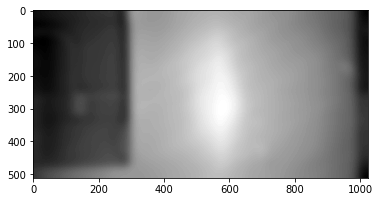

In [19]:
print(len(flats))

g = flats_low_pass[10]
plt.imshow(g, cmap='gray')

In [20]:
def get_similar_flat(image, sigma):
    diff_values = []
    
    image_low_pass = gaussian_filter(image, sigma=sigma)
    
    ixgrid = np.ix_(range(0,image.shape[0],100),range(0,image.shape[1],100))
    
    for fl in flats_low_pass:
        diff_values.append(np.mean(np.abs(image_low_pass[ixgrid] - fl[ixgrid])))
        
    min_index = np.argmin(diff_values)
    
    return flats[min_index]
          

In [21]:
# Comparison test

frame=22

test_images = images[frame:frame+30]

for im in test_images:
      
    # Using average flat field image
    res = np.log((avg_flat.astype(float)  + 0.001) / (im.astype(float)  + 0.001))      
    im_corr = Image.fromarray(res)
    im_corr.save(path + 'flat_avg/' + str(frame) + '_flat_corr_avg.tif')
    
    # Using adaptive flat field image
    best_flat = get_similar_flat(im, sigma)
    res = np.log((best_flat.astype(float)  + 0.001) / (im.astype(float)  + 0.001))      
    im_corr = Image.fromarray(res)
    im_corr.save(path + 'flat_adapt/' + str(frame) + '_flat_corr_adapt.tif')
    
    frame+=1
     

In [14]:
from scipy.ndimage.filters import uniform_filter, gaussian_filter

w = images.shape[2]
h = images.shape[1]

rows = range(80, 80+100)
cols = range(330, 330+100)
patch_empty = np.ix_(rows, cols)


rows = range(80, 120)
cols = range(1000, 1010)
patch_shutter = np.ix_(rows, cols)

rows = range(int(h/2 - h/6), int(h/2 + h/6))
cols = range(int(w/2 - w/6 - 50), int(w/2 + w/6 -50))
patch_spray = np.ix_(rows, cols)


debug = False


if debug:
    frame = 0

    plt.imshow(images[frame][patch_shutter], cmap='gray')
    plt.colorbar()
    plt.show()

    plt.imshow(images[frame][patch_empty], cmap='gray')
    plt.show()

    plt.imshow(images[frame][patch_spray], cmap='gray')
    plt.show()




In [82]:
start_indexes, end_indexes = get_spraying_events(images, max_read_images-1, sigma=15, min_brigthness=15, range_diff_value=0.3)
    
print('OK')
print('Spray events', len(start_indexes))
print(start_indexes)
print(end_indexes)
print('Durations', np.array(end_indexes) - np.array(start_indexes))


OK
Spray events 11
[22, 302, 582, 862, 1143, 1422, 1703, 1960, 2263, 2532, 2824]
[98, 384, 668, 938, 1219, 1499, 1784, 2066, 2343, 2625, 2879]
Durations [ 76  82  86  76  76  77  81 106  80  93  55]


In [56]:
shot_events = [0, 1, 2]

frames = []
batch_size = 40
every_nth = 1

for i in shot_events:
    start = start_indexes[i]
    end = end_indexes[i]
    c = int((end - start) / 2)
    print(c)
    frames.extend(list(range(c-int(batch_size/2), c+int(batch_size/2), every_nth)))
    
print(frames)

49
57
55
[29, 34, 39, 44, 49, 54, 59, 64, 37, 42, 47, 52, 57, 62, 67, 72, 35, 40, 45, 50, 55, 60, 65, 70]


In [13]:
#plt.plot(abs(np.array(diff0_1) - np.array(diff2_3)))
#plt.plot(res_range_empty)
#plt.plot(res_range_spray)
#plt.show()
#
#plt.plot((np.array(res_range_spray) - np.array(res_range_empty)) /  np.array(res_range_spray))
#plt.show()
#
#plt.plot(res_mean_dark)
#plt.show()
#

In [57]:

# top directory for processing results
path_proc = 'proc'

path_raw = proc +    '\\raw'
path_input = proc +  '\\input'
path_amp = proc +    '\\amp'
path_flow_x = proc + '\\flow_x'
path_flow_y = proc + '\\flow_y'
path_corr = proc + '\\corr'

#make_dir(path + path_raw)
#make_dir(path + path_input)
#make_dir(path + path_amp)
#make_dir(path + path_flow_x)
#make_dir(path + path_flow_y)
#make_dir(path + path_corr)
#

Flat-corrected image


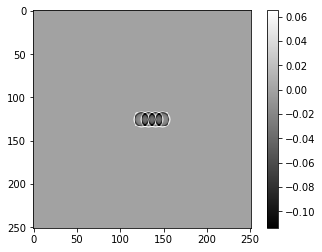

In [5]:
frame = 0

#path = 'e:\\Data\\spray\\simulation\\multiexposure\\'
#path = 'e:\\Data\\spray\\tests\\'
path = 'y:\\projects\\pn-reduction\\ershov\\'

#----------------------------------------
# Make flat field correction
#----------------------------------------

flat_correction = False
flat_automated = False

if flat_correction:
    
    # Automatically Select flat field
    if flat_automated:
        # current sequence event
        seq_num = 0

        # get flats (first frame indicated by start_indexes)
        flats = images[0: start_indexes[seq_num]-1]
        raw = images[frame]

        # avarage flats
        flat = np.mean(flats, axis=0)
     
        im = np.log((flat.astype(float)  + 0.001) / (raw.astype(float)  + 0.001))
        
        im_corr = Image.fromarray(im)
        im_corr.save(path + str(frame) + '_flat_corr.tif')
        
        

        print('Flat field')
        plt.imshow(flat, cmap='gray')
        plt.show()
    
    # Manually Select flat field
    else:
        
        #frame = 'frame01'
        #raw = imread(path + frame + '.tif')
        #raw = imread(path + 'sim_thr100.tif')
        raw = imread(path + 'real_frame-128-128.tif')
        #raw = images[frame]
        #flat = imread(path + 'flat.tif')
        
        #raw = imread(path + 'frame2.tif') # testing sample from 'correlation' folder
        #flat = imread(path + 'flat2.tif')
        
        #im = np.log((flat.astype(float)  + 0.001) / (raw.astype(float)  + 0.001)) # real
        
        #im = np.log((266.0  + 0.001) / (raw.astype(float)  + 0.001)) # Temp!!!!
        
        im = raw.astype(float)
        
        
        im_corr = Image.fromarray(im)
        im_corr.save(path + str(frame) + '_flat_corr.tif')
        
        
    

else:
    #im = imread(path + 'frame01.tif')
    im = images[frame]
    im_corr = Image.fromarray(im)
    im_corr.save(path + str(frame) + '_flat_corr.tif')

print('Flat-corrected image')
#plt.imshow(im, vmin=-0.5, vmax=0.5, cmap='gray')
plt.imshow(im, cmap='gray')
plt.colorbar()
plt.show()


In [6]:
pixel_size = 4.0 # pixel size in micrometers
bunch_period = 176  # 176 ns bunch separation period
time_factor = bunch_period / 1000.0   # in microseconds
vel_factor = pixel_size / time_factor

print(vel_factor)

22.72727272727273


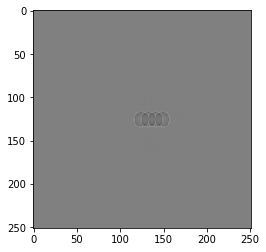

  0%|                                                  | 0/221 [00:00<?, ?it/s]


TypeError: only size-1 arrays can be converted to Python scalars

In [7]:
window_size = 30

# Crop frame
xmin = 250
xmax = 950
ymin = 50
ymax = 450

# Centeral path
xmin = 90
xmax = 90+50
ymin = 120
ymax = 120+50

#plt.imshow(im[ymin:ymax, xmin:xmax], vmin=-0.5, vmax=0.5, cmap='gray')
plt.imshow(im, vmin=-0.5, vmax=0.5, cmap='gray')
plt.show()


# Compute cropped region
#amp, vx, vy, corr = compute_flow_area(im, window_size, xmin, xmax, ymin, ymax)

# Compute full frame
amp, vx, vy, corr, peak_h = compute_flow_area(im, int(window_size), int(window_size / 2), int(im.shape[1] - window_size / 2) , int(window_size / 2), int(im.shape[0] - window_size / 2))
print('OK')

In [7]:
amp = amp*vel_factor

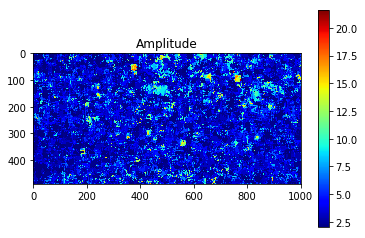

In [8]:
plt.imshow(amp, cmap='jet')
plt.title('Amplitude')
plt.colorbar()
plt.show()

im_res = Image.fromarray(amp)
im_res.save(path + str(frame) +'_res_amp_w_'+str(window_size)+'.tif')

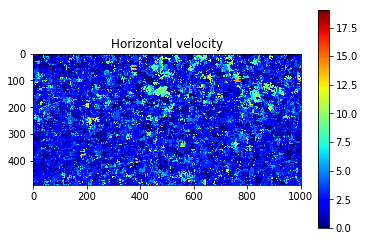

In [9]:
plt.imshow(vx, cmap='jet')
plt.title('Horizontal velocity')
plt.colorbar()
plt.show()

im_res = Image.fromarray(vx)
im_res.save(path + str(frame) + '_res_x_w_'+str(window_size)+'.tif')

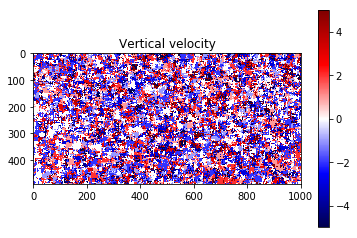

In [10]:
plt.imshow(vy, vmin=-5, vmax=5, cmap='seismic')
plt.title('Vertical velocity')
plt.colorbar()
plt.show()

im_res = Image.fromarray(vy)
im_res.save(path + str(frame) + '_res_y_w_'+str(window_size)+'.tif')

In [11]:
#plt.imshow(errors, cmap='gray')
#plt.show()

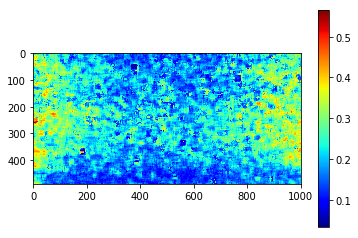

In [12]:
plt.imshow(corr, cmap='jet')
plt.colorbar()
plt.show()

im_res = Image.fromarray(corr)
im_res.save(path + str(frame) + '_res_corr_w_'+str(window_size)+'.tif')

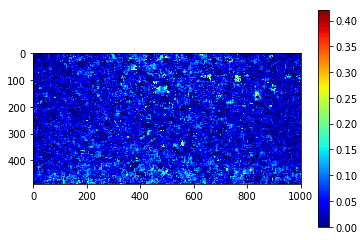

In [13]:
plt.imshow(peak_h, cmap='jet')
plt.colorbar()
plt.show()

im_res = Image.fromarray(peak_h)
im_res.save(path + str(frame) + '_res_peak_height_'+str(window_size)+'.tif')

In [16]:
def make_squares():
    im = np.zeros((30,30))

    cx = int(im.shape[1] / 2)
    cy = int(im.shape[0] / 2)

    w = 3

    shiftx = 10
    shifty = 5

    im[cy-w:cy+w, cx-w: cx+w] = 255
    im[cy-w+shifty:cy+w+shifty, cx-w+shiftx: cx+w+shiftx] = 255

    #im[cy-w-20:cy+w-30, cx-w+10: cx+w+10] = 255

    im +=np.random.normal(2*im+2,60)

    plt.imshow(im, cmap='gray')
    
    return im

    

In [123]:
#im = make_squares()

(9,)


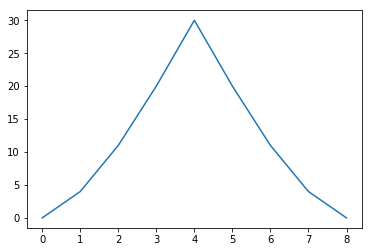

[ 0.00000000e+00  3.86666667e+00  1.06333333e+01  1.93333333e+01
  2.90000000e+01  1.93333333e+01  1.06333333e+01  3.86666667e+00
 -5.26327952e-17]


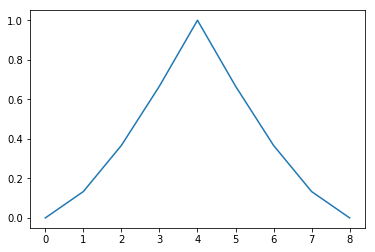

In [3]:
x = np.array([0,1,2,3,4])
my_corr = my_correlation_1d(x, show=True)

corr = fftconvolve(x, x[::-1], mode='full') / np.sum(x ** 2)
plt.plot(corr)

print(my_corr - corr)

In [4]:
debug = True

Time elapsed:  2.8450305461883545


In [6]:
#------------------------------------------------------
# Correlation and Find peaks
#------------------------------------------------------

# My peaks finding procedure
#inds, values = my_find_peaks(my_corr, min_distance=2, peak_threshold=0.01, show=True)

#print(values)

def find_correlation(imx, sigma=0.0):
    
    #if sigma > 0.0:
        #imx = gaussian_filter(imx, sigma)
    
    # My correlation procedure
    #my_corr = my_correlation3(a, show=True)

    #x = np.ones_like(a)
    #norm = fftconvolve(x, x[::-1, ::-1], mode='full') 
    corr = fftconvolve(imx, imx[::-1, ::-1], mode='same') / np.sum(imx ** 2)

    print('Shape:', corr.shape)
    
    if sigma > 0.0:
        corr = gaussian_filter(corr, sigma)
    
    maxima_ind = peak_local_max(corr, min_distance=1, num_peaks=7)
    maxima = sorted(corr[maxima_ind[:,0], maxima_ind[:,1]])
    
    print('')

    print('# local peaks', len(maxima))
    #print('Peaks indexes: \n', maxima_ind)

    print (maxima)

    if (len(maxima) == 1):
        print('Warning: One peak!')
        plt.imshow(corr, cmap='jet')
        plt.show()
        return corr

    v1 = maxima[-2]
    v2 = maxima[-3]

    print('Peaks:', v1, v2)

    # select indexes of two peaks
    index1 = np.where(corr == v1)

    #print index1
    # when both maxima are equal
    #print len(index1)
    if len(index1[0]) > 1:
        index2 = [index1[0][0], index1[1][0]] 
        index1 = [index1[0][1], index1[1][1]] 
    else:
        index2 = np.where(corr == v2)

    # movement to the right
    if index1[1] > corr.shape[1] / 2.0:
        index = index1
    else:
        index = index2

    #print('Index:', index )
    
    # --------------------------------------
    # Peak width analysis
    # --------------------------------------
    #local_maxi = peak_local_max(corr, min_distance=2, indices=False, num_peaks=7)
    #
    ## Manual markers
    #markers = np.zeros_like(corr)
    #markers[index1[0], index1[1]] = 5
    #markers[index2[0], index2[1]] = 10
    #
    #markers = label(local_maxi)[0] 
    #
    #
    #plt.imshow(markers, cmap='gray')
    #plt.colorbar()
    #plt.show()
    
    
    # Test 1: Watershed 
    #labels = watershed(1.0 - corr, markers, watershed_line=True)
    #plt.imshow(labels, cmap='gray')
    #plt.colorbar()
    #plt.show() 
    #im_res = Image.fromarray(labels)
    #im_res.save(path + str(frame).zfill(4) + '_peak_watershed.tif')
    #
    #
    #props = regionprops(labels)
    #peak_area = 0   
    #for reg in props:
    #    if reg.label == max_peak_label:
    #        peak_area = reg.area
    #
    #print('Peak area', peak_area)
    
    # Test 2: Watershed on edges via Sobel 
    #edges = sobel(corr-0.00001)
    #plt.imshow(edges, cmap='gray')
    #plt.show()
    
    #labels = watershed(edges, markers)
    #
    #max_peak_label = labels[index[0], index[1]]
    ##print(max_peak_label)
#
    #plt.imshow(labels, cmap='gray')
    #plt.colorbar()
    #plt.title('Water on sobel')
    #plt.show()
    #
    #print(type(labels))
    #
    #props = regionprops(labels.astype(int))
    #peak_area = 0   
    #for reg in props:
    #    if reg.label == max_peak_label:
    #        peak_area = reg.area
    #
    #print('Sobel peak area', peak_area)
    #
    
    # Test 3: Noise detection - Analyze neighborhood of the center peak 
    #n = corr[w-1-1:w+1,w-1-1:w+1]
    #avg_n = (np.sum(n) - 1.0) / 8.0
    #print('Mean around centeral peak:', avg_n)
#
    #if avg_n < 0.5:
    #    print('It is noisy here!')
    #
        
    x, y = index[1], index[0]
    vec = math.ceil(y - corr.shape[0] / 2.0), math.ceil(x - corr.shape[1] / 2.)
    amp = np.sqrt(np.dot(vec, vec))
    c = corr[y, x]
    
    # Get peak height
    p = get_peak_height(corr, int(corr.shape[0]/2),int(corr.shape[1]/2),vec[1],vec[0])

    # Setup figure
    
    fig = plt.figure(1)
    fig.set_size_inches(10, 3, forward=True)
    plt.subplots_adjust(top=0.95, bottom=0.06, left=0.1, right=0.90, hspace=0.3 )
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1])

    ax0 = plt.subplot(gs[0,0])
    imx0 = ax0.imshow(imx, cmap='gray')
    plt.colorbar(imx0, ax=ax0)


    # Set central peak (1.0) to zero to improve contrast
    #corr[int(w/2),int(w/2)] = 0
    
    ax1 = plt.subplot(gs[0,1])
    imx1 = ax1.imshow(corr, vmax=0.4,cmap='jet')
    ax1.scatter(maxima_ind[:,1],maxima_ind[:,0], c='black')
    ax1.scatter(index[1], index[0], c='white')
    plt.colorbar(imx1, ax=ax1)
    
    
    plt.show()
    
    print('Vec (y,x):', vec)
    print('Amp:', amp)
    print('Corr:', c)

    
    return corr
     
    #print(corr[w-1,:])
    #plt.plot(corr[w-1,:])
    #plt.scatter(index1[1], 1, c='r')
    #plt.scatter(index2[1], 1, c='r')
    #plt.show()
    
    
def get_peak_height(c, x0,y0,vx,vy):

    dist = math.sqrt(vx**2 + vy**2)
    #print('Dist', dist)
    s = vx / dist
    #print(s)
    xs = np.arange(s, vx, s)

    min_value = 1000

    #profile = []
    for xi in xs:
        yi = (vy / vx)*xi

        x = math.floor(xi)
        y = math.floor(yi)

        dx = xi - x
        dy = yi - y

        val = (1.0-dx)*(1.0-dy)*c[y0+y,x0+x] + (1.0-dx)*dy*c[y0+y+1,x0+x] +dx*(1.0-dy)*c[y0+y,x0+x+1] + dx*dy*c[y0+y+1,x0+x+1]

        if val < min_value:
            min_value = val

        #profile.append(val)

    selected_peak = c[y0+vy,x0+vx]
    #print(selected_peak)   
    #print(profile)
    peak_height = selected_peak - min_value

    return peak_height

In [3]:
max_read_images = 10 # all: 2880

#path = 'e:\\Data\\spray\\correlation\\025_1_new\\'
path = 'y:\\projects\\pn-reduction\\2018_09_esrf_me1516\\Phantom\\17_3_23_1\\17_3_23_1_Tile_d20\\'
path = 'y:\\projects\\pn-reduction\\ershov\\params_scan\\params_scan_param_all_v2\\'

start = time()
#images = read_tiff(path + 'input.tif', max_read_images)
#images = read_tiff(path + '17_3_23_1_Tile_d20_flat_seq.tif', max_read_images)
images = read_tiff(path + 'params_scan_Tile_dall_flat_seq.tif', max_read_images)

#amp_w15 = read_tiff('e:\\Data\\spray\\correlation\\025_1_no_trans_w15\\025_1_no_trans_w15_Z0_amp_seq.tif', max_read_images)
#amp_w30 = read_tiff(path + '025_1_new_Z0_amp_seq.tif', max_read_images)

#comp_amp_images = read_tiff(path + '17_3_23_1_Tile_d20_amp_seq.tif', max_read_images)
#comp_corr_images = read_tiff(path + '17_3_23_1_Tile_d20_corr_seq.tif', max_read_images)

comp_amp_images = read_tiff(path + 'params_scan_Tile_dall_amp_seq.tif', max_read_images)
comp_corr_images = read_tiff(path + 'params_scan_Tile_dall_corr_seq.tif', max_read_images)

end = time()

print ('Time elapsed: ', (end-start))

Time elapsed:  1.1509997844696045


## Manually check correlation

In [4]:
def plot_correlation():
    
    #amp15 = amp_w15[frame-1]
    #amp30 = amp_w30[frame-1]
    image = images[frame-1]
    comp_amp = comp_amp_images[frame-1]
    comp_corr = comp_corr_images[frame-1]

    #im1 = image[int(cy-w/2):int(cy+w/2), int(cx-w/2): int(cx+w/2)]
    im1 = image[cy-int(w/2):cy+int(w/2), cx-int(w/2): cx+int(w/2)]

    im_res = Image.fromarray(im1)
    im_res.save(path + str(frame).zfill(4) + '_input.tif')

    corr1 = find_correlation(im1)

    im_res = Image.fromarray(corr1)
    im_res.save(path + str(frame).zfill(4) + '_peak.tif')

    print('')
    print('-------  Computed on GPU ----------')
    print('Amp: ', comp_amp[cy,cx])
    print('Corr: ', comp_corr[cy,cx])
    
    return corr1
   

Shape: (30, 30)

# local peaks 7
[0.24366498, 0.24366501, 0.26675487, 0.2667549, 0.5230208, 0.5230208, 1.0000001]
Peaks: 0.5230208 0.5230208


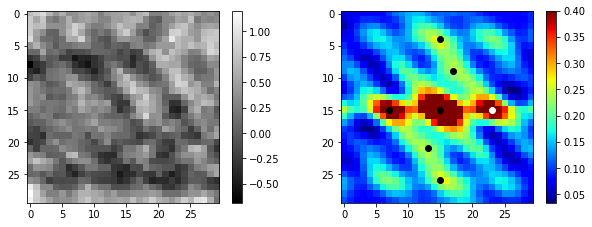

Vec (y,x): (0, 8)
Amp: 8.0
Corr: 0.5230208

-------  Computed on GPU ----------
Amp:  8.0
Corr:  0.5230209


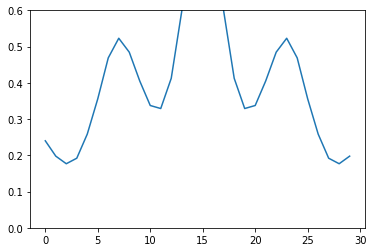

[0.24010168 0.19772252 0.176784   0.1920157  0.2586081  0.35590917
 0.46893373 0.5230208  0.48461828 0.40512645 0.33746764 0.32911628
 0.41245964 0.5972451  0.80761284 1.0000001  0.80761284 0.59724504
 0.4124596  0.32911628 0.33746764 0.40512645 0.48461828 0.5230208
 0.4689338  0.3559092  0.25860813 0.19201575 0.17678402 0.19772252]
Shape: (30, 30)

# local peaks 5
[0.08074149, 0.13070787, 0.55709827, 0.55709827, 1.0000002]
Peaks: 0.55709827 0.55709827


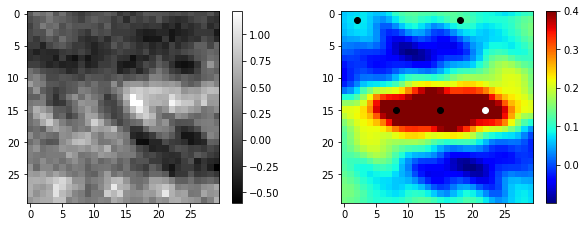

Vec (y,x): (0, 7)
Amp: 7.0
Corr: 0.55709827

-------  Computed on GPU ----------
Amp:  7.0
Corr:  0.557098


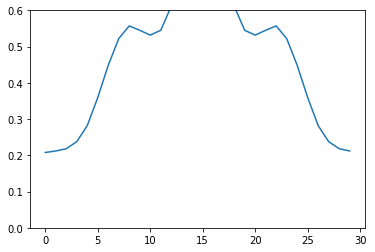

[0.207819   0.21197283 0.21823813 0.23770525 0.28197598 0.3595236
 0.44855016 0.52214164 0.55709827 0.54502565 0.53170294 0.5450215
 0.6113552  0.73731166 0.86925685 1.0000002  0.86925685 0.73731166
 0.6113552  0.5450215  0.53170294 0.54502565 0.55709827 0.52214164
 0.44855013 0.35952362 0.28197604 0.2377052  0.21823816 0.21197289]


In [19]:
w = 30 

# empty
cx = 140
cy = 110
frame = 1 # start from one

c = plot_correlation()
plt.plot(c[int(w/2)-0,:])
plt.ylim(0,0.6)
plt.show()
print(c[int(w/2)-0,:])

# good correlation
cx = 182
cy = 90
frame = 1 # start from one

c = plot_correlation()
plt.plot(c[int(w/2)-0,:])
plt.ylim(0,0.6)
plt.show()
print(c[int(w/2)-0,:])

## Cross correlation




           



In [78]:
#------------------------------------------------------
# Correlation and Find peaks
#------------------------------------------------------

# My peaks finding procedure
#inds, values = my_find_peaks(my_corr, min_distance=2, peak_threshold=0.01, show=True)

#print(values)

def find_cross_correlation(patch, source):
    
    #if sigma > 0.0:
        #imx = gaussian_filter(imx, sigma)
    
    # My correlation procedure
    #my_corr = my_correlation3(a, show=True)

    #x = np.ones_like(a)
    #norm = fftconvolve(x, x[::-1, ::-1], mode='full') 
    corr = fftconvolve(source, patch[::-1, ::-1], mode='same')

    print('Shape:', corr.shape)
 
    maxima_ind = peak_local_max(corr, min_distance=1, num_peaks=7)
    maxima = sorted(corr[maxima_ind[:,0], maxima_ind[:,1]])
    
    print('')

    print('# local peaks', len(maxima))
    #print('Peaks indexes: \n', maxima_ind)

    print (maxima)

    v = maxima[-1]

    print('Peak:', v)

    # select indexes of two peaks
    index = np.where(corr == v)
   
    x, y = index[1], index[0]
    vec = math.ceil(y - corr.shape[0] / 2.0), math.ceil(x - corr.shape[1] / 2.)
    amp = np.sqrt(np.dot(vec, vec))
    c = corr[y, x]
    

    # Setup figure
    
    fig = plt.figure(1)
    fig.set_size_inches(10, 3, forward=True)
    plt.subplots_adjust(top=0.95, bottom=0.06, left=0.1, right=0.90, hspace=0.3 )
    gs = gridspec.GridSpec(1, 2, width_ratios=[1,1])

    ax0 = plt.subplot(gs[0,0])
    imx0 = ax0.imshow(patch, cmap='gray')
    plt.colorbar(imx0, ax=ax0)


    # Set central peak (1.0) to zero to improve contrast
    #corr[int(w/2),int(w/2)] = 0
    
    ax1 = plt.subplot(gs[0,1])
    imx1 = ax1.imshow(corr,cmap='jet')
    ax1.scatter(maxima_ind[:,1],maxima_ind[:,0], c='black')
    ax1.scatter(index[1], index[0], c='white')
    plt.colorbar(imx1, ax=ax1)
    
    
    plt.show()
    
    print('Vec (y,x):', vec)
    print('Amp:', amp)
    print('Corr:', c)

    
    return corr
     
    #print(corr[w-1,:])
    #plt.plot(corr[w-1,:])
    #plt.scatter(index1[1], 1, c='r')
    #plt.scatter(index2[1], 1, c='r')
    #plt.show()
    



C:\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  """
C:\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  


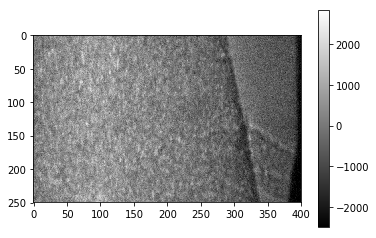

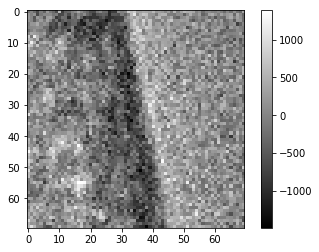

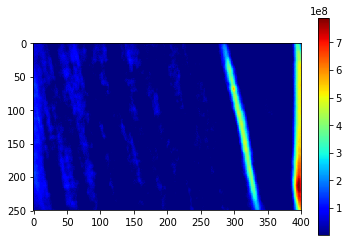

float64
92694853.17224428
[10, 10]


In [91]:
from scipy.signal import correlate2d

path = 'y:\\projects\\pn-reduction\\ershov\\speckle\\'

source = imread(path + 'ref.tif')
target = imread(path + 'im.tif')

w = 70

# Center of the patch
cx = 300
cy = 70

patch = target[cy-int(w/2):cy+int(w/2), cx-int(w/2): cx+int(w/2)]

m_s = np.mean(source)
m_p = np.mean(patch)

source = source.astype(np.float) - m_s
patch = patch.astype(np.float) - m_p

#source = np.sum(np.gradient(np.array(source).astype(np.float)), axis=0) # np.array(image_pil)
#patch = np.sum(np.gradient(np.array(patch).astype(np.float)), axis=0) #np.array(template_pil)


#corr = find_cross_correlation(patch, source)


corr = correlate2d(source.astype(float), patch.astype(float), mode='same')

plt.imshow(source, cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(patch, cmap='gray')
plt.colorbar()
plt.show()

plt.imshow(corr, vmin=1e6, cmap='jet')
plt.colorbar()
plt.show()

print(patch.dtype)

print(corr[50,50])

print([10,10])


In [76]:
plt.imshow(c, cmap='gray')

vec = (-1, 10)
x0 = int(c.shape[0]/2)
y0 = int(c.shape[1]/2)

selected_peak = c[y0+vec[0],x0+vec[1]]
print('Selected peak:', selected_peak)

peak_h, profile = get_peak_height(x0, y0, vec[1], vec[0])


print('Peak height:', peak_h)    

if peak_h > selected_peak / 2.0:
    print('Good peak!')
else:
    print(':-(')

NameError: name 'c' is not defined

[0.3250056662435063, 0.24527829017265806, 0.1371678679281268, 0.0554625970815483, -0.010083642355940574, 0.002734309901470642, 0.011601240344854971, 0.05743866918057397, 0.10845685598463348, 0.1470832376511495]


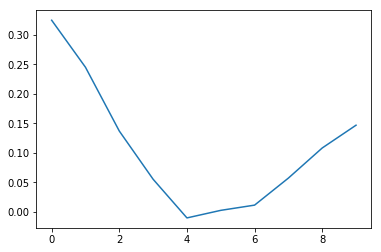

In [231]:
plt.plot(profile)
print(profile)

In [99]:
#plt.plot(1.0 - corr1[w-1,:])

In [73]:
#pwidth = imread(path + '0030_res_width.tif')

C:\Anaconda2\envs\py36\lib\site-packages\ipykernel_launcher.py:7: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.
  import sys


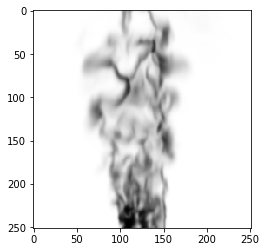

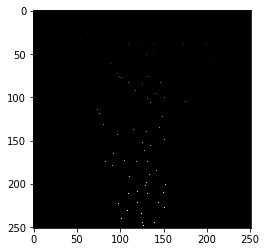

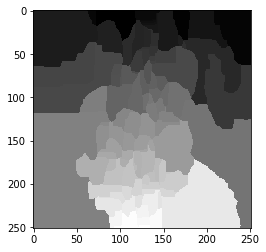

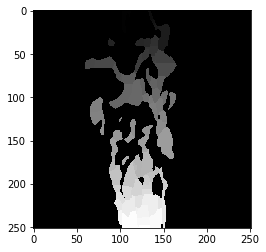

In [39]:
from scipy import ndimage
from skimage import data
from skimage.morphology import extrema, watershed

path = "e:\\Data\\spray\\CFD_Simulations\\stats_4data_box1p00\\"

im = imread(path + 'spray_slice.tif')

corr1 = im

corr1 = gaussian_filter(corr1, 1.0)

plt.imshow(-corr1, cmap='gray')
plt.show()

local_maxi = peak_local_max(corr1, indices=False, num_peaks=100)

markers = label(local_maxi)[0]


plt.imshow(markers, cmap='gray')
plt.show()
im_res = Image.fromarray(markers)
im_res.save(path + 'markers.tif')

#maxima = extrema.h_minima(corr2, 0.4)
labels = watershed(-corr1, markers)

plt.imshow(labels, cmap='gray')
plt.show()
im_res = Image.fromarray(labels)
im_res.save(path + 'labels.tif')

mask = np.where(corr1 > 170, 1.0, 0.0)
labels=labels*mask

plt.imshow(labels, cmap='gray')
plt.show()
im_res = Image.fromarray(labels)
im_res.save(path + 'labels_masked.tif')



In [33]:
if False:
    from skimage.morphology import disk
    from skimage.filters.rank import gradient
    from skimage.filters import sobel

    edges = sobel(corr1)
    plt.imshow(edges, cmap='gray')
    plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape

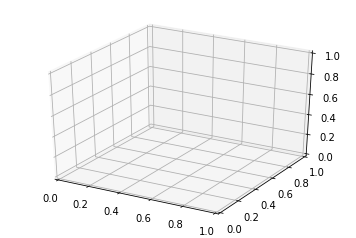

In [120]:

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
x = range(0, 2*w-1)
y = range(0, 2*w-1)
xc, yc = np.meshgrid(x, y)

ax.plot_surface(xc,yc,corr, cmap='jet')
plt.show()


In [25]:
 # My
print('=============================================')
print('=============================================')
#x, y, amp, c = select_peak(my_corr, inds[0], inds[1], values)


In [18]:
w = 1024 / 4
h = 512 / 2

w = 64
h = 64
r = 16

buffers = 2

float_size = 4

print('Image: ', int(w),'x',int(h))
print('Memory needed', w*h*r*r*buffers*float_size / (1024 * 1024), 'MB')
print(w*r)

Image:  64 x 64
Memory needed 8.0 MB
1024


In [88]:
# Proccessing time calculation
frames = 40
shots = 5
t = 5
processors = 35

print(frames*shots, 'images')
print(frames*shots*t / processors, 'min')

200 images
28.571428571428573 min


In [77]:
14*24

336

Real time

In [85]:
print(2050/(frames*shots))

10.25


In [86]:
print(2050/60)

34.166666666666664


In [12]:
print(5*60 / 0.3 )

1000.0


In [1]:
from data_profiles import *

In [2]:
exp1

{'dataset_name': '2018_09_ersf_mi1516',
 'root_path': '/mnt/LSDF/projects/pn-reduction/2018_09_esrf_me1516/Phantom/',
 'datasets': ['17_3_18_1', '17_3_23_1', '17_3_5_1', '17_3_7_3'],
 'params': ['0', '2.5', '5', '7.5', '10', '12.5', '15', '17.5', '20'],
 'param_name': '_Tile_d',
 'image_size': (0, 0, 1024, 512),
 'flip_image': False,
 'spray_mode': <Spraying.multiple: 2>,
 'num_frames': 3348,
 'spray_mode_params': {'start_events_offsets': [0, 2, 4, 6, 8, 10, 12, 14, 16],
  'spray_duration': 94,
  'spray_events_separation': 224,
  'batch_size': 50,
  'use_every_nth': 1},
 'flat_mode': <FlatField.adaptive: 3>,
 'adaptive_flat': {'sigma': 15.0, 'flat_num': 20, 'flat_offset': 20},
 'clean_intermediate_results': True}

In [6]:
print('ad', np.range(14))

NameError: name 'np' is not defined

In [3]:
# coding: utf-8
import numpy as np
import sys
import math
import os
import time as t

from os import listdir
from os.path import isfile, join

from scipy.ndimage import imread
from scipy import ndimage

from PIL import Image

import subprocess
from tqdm import tqdm

from utils import *
from numerics import smooth
from data_profiles import *

exec_path     = '/mnt/LSDF/anka-nc-cluster/home/ws/fe0968/autocorr-concert/'
corr_exec     = 'autocorr'

input_frame_file = 'frame_corr.raw'
#path_flow_input = '/mnt/LSDF/anka-nc-cluster/home/ws/fe0968/autocorr/data/'

In [5]:
# Load data processing profile
p = exp1

clean_intermediate_results = p['clean_intermediate_results']
flat_mode = p['spray_mode']

print(clean_intermediate_results)

True


In [8]:
print(np.arange(14))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
